🔁 Mínimo local detectado — fallback A*.
✅ Caminho encontrado usando A* (fallback).


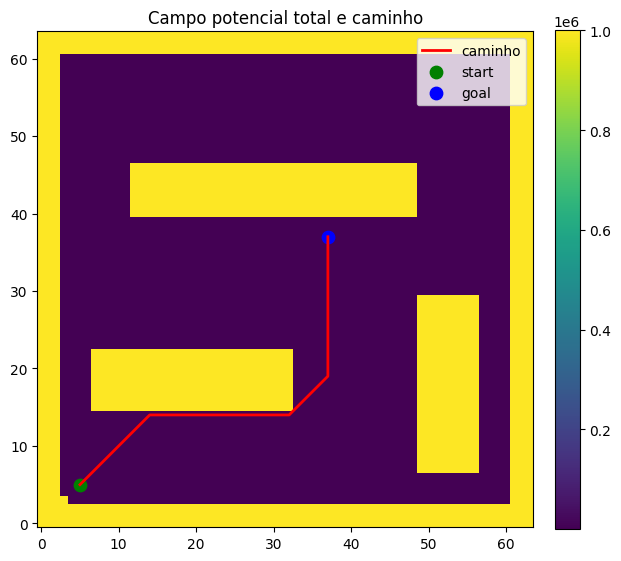

RuntimeError: Não foi possível obter handle do robô no CoppeliaSim. Erro: 1254: in sim._getObject: object does not exist, or alias/path is ill formatted.

In [2]:
# ============================
# Planner por Campos Potenciais + Simulação CoppeliaSim
# ============================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import heapq

# tenta importar client do Coppelia; se não estiver disponível, avisa mas permite testar planner offline
try:
    from coppeliasim_zmqremoteapi_client import RemoteAPIClient
    COPPELIA_AVAILABLE = True
except Exception as e:
    print("⚠️ Atenção: coppeliasim_zmqremoteapi_client não encontrado. Apenas planner será executado. Erro:", e)
    COPPELIA_AVAILABLE = False


# ============================
# Funções utilitárias
# ============================
def pixel_to_world(x_px, y_px, img_size=64, world_size=10):
    """
    Converte coordenadas de pixel (x_px = coluna, y_px = linha) para coordenadas do CoppeliaSim (metros).
    O centro da imagem (img_size/2, img_size/2) corresponde à origem (0,0) no mundo.
    Retorna (x_world, y_world).
    """
    scale = world_size / img_size  # metros por pixel
    x_world = (x_px - img_size / 2) * scale
    y_world = -(y_px - img_size / 2) * scale  # inverte Y porque imagem cresce para baixo
    return x_world, y_world

def Rz(theta):
    """Matriz de rotação 3x3 no plano Z."""
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])


# ============================
# Carregar imagem e construir grid (64x64)
# ============================
img_path = '../mapas_meus/teste1_invertido.png'  # ajuste se necessário
img = mpimg.imread(img_path)

# inverter (já no seu código original você fazia 1 - imagem)
img = 1 - img

# limitar a dois níveis (0 e 1)
threshold = 0.5
img = img[..., 0] if img.ndim == 3 else img  # se imagem RGBA/ RGB, pega primeiro canal
img[img > threshold] = 1
img[img <= threshold] = 0

# dimensões do mapa (em células/meters) e escala
map_dims = np.array([64, 64])  # X,Y em "células" (seu map)
img_h, img_w = img.shape[:2]

# escala para agrupar pixels em uma célula (caso imagem tenha maior resolução)
sy = img_h / map_dims[1]  # pixels por célula em Y (note a ordem)
sx = img_w / map_dims[0]  # pixels por célula em X

cell_size = 1  # metros por célula (coerente com map_dims)
rows, cols = map_dims[1], map_dims[0]  # rows=64, cols=64
grid = np.zeros((rows, cols), dtype=int)

# preencher grid: soma de pixels dentro da célula -> depois binariza
for r in range(rows):
    for c in range(cols):
        xi = int(round(c * sx))
        xf = int(round((c + 1) * sx))
        yi = int(round(r * sy))
        yf = int(round((r + 1) * sy))

        # clamp para bordas
        xi = max(0, min(img_w - 1, xi))
        xf = max(1, min(img_w, xf))
        yi = max(0, min(img_h - 1, yi))
        yf = max(1, min(img_h, yf))

        patch = img[yi:yf, xi:xf]
        if patch.size == 0:
            grid[r, c] = 0
        else:
            grid[r, c] = 1 if np.sum(patch) / patch.size > 0.5 else 0

# agora grid: 1 = ocupado, 0 = livre
# (Se preferir inversão, comente a linha abaixo)
grid = grid.astype(int)

# ============================
# Funções do planner por campo potencial (com fallback A*)
# ============================
def compute_distance_to_obstacles(grid):
    """Calcula distância euclidiana de cada célula até o obstáculo mais próximo."""
    rows, cols = grid.shape
    ys, xs = np.indices((rows, cols))
    obs = np.argwhere(grid == 1)
    if obs.size == 0:
        return np.full((rows, cols), np.hypot(rows, cols))
    # vetorizado: para cada obstáculo calcula-se matriz de dist; em memória pode ser pesado mas 64x64 ok
    oy = obs[:, 0][:, None, None]
    ox = obs[:, 1][:, None, None]
    dists = np.sqrt((ys[None, :, :] - oy)**2 + (xs[None, :, :] - ox)**2)
    dmin = dists.min(axis=0)
    return dmin

def potential_field_planner(grid, start, goal,
                            ka=1.0,
                            eta=300.0,
                            d0=6.0,
                            step_limit=20000,
                            visualize=True):
    """
    Monta campo potencial e obtém caminho por descida de gradiente.
    start, goal: (row, col)
    Retorna pos (dict idx -> (x_px, y_px)), path (lista de idx), U (campo potencial)
    """
    rows, cols = grid.shape
    sy, sx = np.indices((rows, cols))
    gy, gx = goal
    dist_to_goal = np.sqrt((sy - gy)**2 + (sx - gx)**2)
    U_att = 0.5 * ka * dist_to_goal**2

    dist_to_obs = compute_distance_to_obstacles(grid)
    U_rep = np.zeros_like(dist_to_obs, dtype=float)

    with np.errstate(divide='ignore', invalid='ignore'):
        mask = dist_to_obs <= d0
        U_rep[mask] = 0.5 * eta * (1.0 / (dist_to_obs[mask] + 1e-9) - 1.0 / d0)**2
        U_rep[grid == 1] = 1e6  # células ocupadas muito caras

    U = U_att + U_rep

    moves8 = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]

    cur = start
    path_coords = []
    visited = set()
    it = 0
    stuck_counter = 0
    max_stuck = 40

    while True:
        path_coords.append(cur)
        if cur == goal:
            break
        it += 1
        if it > step_limit:
            print("⚠️ Limite de iterações no gradiente excedido.")
            break

        cy, cx = cur
        cur_val = U[cy, cx]

        best = cur
        best_val = cur_val
        for dy, dx in moves8:
            ny, nx = cy + dy, cx + dx
            if 0 <= ny < rows and 0 <= nx < cols and grid[ny, nx] == 0:
                v = U[ny, nx]
                if v < best_val:
                    best_val = v
                    best = (ny, nx)

        if best == cur:
            stuck_counter += 1
            # tentativa de escape suave: escolher vizinho de menor valor (mesmo que maior que cur)
            smallest = None
            smallest_val = np.inf
            for dy, dx in moves8:
                ny, nx = cy + dy, cx + dx
                if 0 <= ny < rows and 0 <= nx < cols and grid[ny, nx] == 0:
                    v = U[ny, nx]
                    if v < smallest_val:
                        smallest_val = v
                        smallest = (ny, nx)
            if smallest is None:
                print("🚫 Start bloqueado.")
                break
            if smallest in visited or stuck_counter > max_stuck:
                print("🔁 Mínimo local detectado — fallback A*.")
                break
            cur = smallest
            visited.add(cur)
            continue
        else:
            cur = best
            visited.add(cur)

    # Se não chegou ao goal via gradiente, faz A*
    if path_coords[-1] != goal:
        def astar(grid, start, goal):
            rows, cols = grid.shape
            def h(a,b):
                return abs(a[0]-b[0]) + abs(a[1]-b[1])
            openset = []
            heapq.heappush(openset, (h(start,goal), 0, start, None))
            came_from = {}
            gscore = {start:0}
            closed = set()
            while openset:
                f, g, current, parent = heapq.heappop(openset)
                if current in closed:
                    continue
                came_from[current] = parent
                if current == goal:
                    path = []
                    cur = current
                    while cur is not None:
                        path.append(cur)
                        cur = came_from[cur]
                    return path[::-1]
                closed.add(current)
                cy, cx = current
                for dy, dx in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
                    ny, nx = cy+dy, cx+dx
                    if 0 <= ny < rows and 0 <= nx < cols and grid[ny,nx] == 0:
                        ng = g + np.hypot(dy, dx)
                        if (ny,nx) not in gscore or ng < gscore[(ny,nx)]:
                            gscore[(ny,nx)] = ng
                            heapq.heappush(openset, (ng + h((ny,nx), goal), ng, (ny,nx), current))
            return None

        astar_path = astar(grid, start, goal)
        if astar_path is None:
            raise RuntimeError("A* também falhou - não foi possível achar caminho")
        path_coords = astar_path
        print("✅ Caminho encontrado usando A* (fallback).")

    # converter para pos e path no formato esperado
    pos = {}
    path = []
    for i, (r, c) in enumerate(path_coords):
        pos[i] = (int(c), int(r))   # (x_px, y_px)
        path.append(i)

    # visualização
    if visualize:
        plt.figure(figsize=(7,7))
        plt.title("Campo potencial total e caminho")
        im = plt.imshow(U, origin='upper')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ys = [p[0] for p in path_coords]
        xs = [p[1] for p in path_coords]
        plt.plot(xs, ys, '-r', linewidth=2, label='caminho')
        plt.scatter([start[1]], [start[0]], c='green', s=80, label='start')
        plt.scatter([goal[1]], [goal[0]], c='blue', s=80, label='goal')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.show()

    return pos, path, U


# ============================
# Parâmetros Start / Goal (no formato row, col)
# ============================
start = (5, 5)
goal  = (37, 37)

# verificar se start/goal estão livres
if grid[start[0], start[1]] == 1:
    raise RuntimeError("Start está dentro de um obstáculo. Ajuste a posição inicial.")
if grid[goal[0], goal[1]] == 1:
    raise RuntimeError("Goal está dentro de um obstáculo. Ajuste a posição final.")

# rodar planner
pos, path, U = potential_field_planner(grid, start, goal,
                                       ka=1.0, eta=300.0, d0=6.0,
                                       step_limit=20000,
                                       visualize=True)

# ============================
# Converter pos -> pos_world (em metros) usando pixel_to_world
# ============================
pos_world = {}
for node, (x_px, y_px) in pos.items():
    pos_world[node] = pixel_to_world(x_px, y_px, img_size=64, world_size=10)

# ============================
# --- INÍCIO DA PARTE DE SIMULAÇÃO (CoppeliaSim) ---
# ============================
if COPPELIA_AVAILABLE:
    client = RemoteAPIClient()
    sim = client.require("sim")

    try:
        sim.setStepping(True)
    except Exception:
        # algumas versões usam stepping diferente; tentar segurança
        pass

    robotname = 'robotino'
    try:
        robotHandle = sim.getObject('/' + robotname)
    except Exception as e:
        # algumas implementações usam getObjectHandle
        try:
            robotHandle = sim.getObjectHandle('/' + robotname)
        except:
            raise RuntimeError("Não foi possível obter handle do robô no CoppeliaSim. Erro: " + str(e))

    # posição inicial (usar o primeiro nó do path)
    start_node = path[0]
    start_px = pos[start_node]  # (x_px, y_px) = (coluna, linha)
    start_pos_xy = pixel_to_world(start_px[0], start_px[1], img_size=64, world_size=10)
    start_pos = [start_pos_xy[0], start_pos_xy[1], 0.04]  # z pequeno
    start_ori = [0, 0, np.deg2rad(90)]  # orientação inicial (90°)

    # garantir sim parada antes de setar
    try:
        if sim.getSimulationState() != 0:
            sim.stopSimulation()
            time.sleep(1)
    except Exception:
        pass

    # setar posição e orientação
    try:
        sim.setObjectPosition(robotHandle, sim.handle_world, start_pos)
        sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori)
        sim.step()
    except Exception as e:
        print("⚠️ Warning: não foi possível setar posição/orientação diretamente. Erro:", e)

    # iniciar simulação
    try:
        sim.startSimulation()
        sim.step()
    except Exception as e:
        print("⚠️ Erro iniciando simulação:", e)

    print("✅ Simulação iniciada e robô posicionado no ponto inicial!")

    # handles das rodas
    try:
        wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
        wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
        wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')
    except Exception:
        # fallback para getObjectHandle
        wheel1 = sim.getObjectHandle(f'/{robotname}/wheel0_joint')
        wheel2 = sim.getObjectHandle(f'/{robotname}/wheel1_joint')
        wheel3 = sim.getObjectHandle(f'/{robotname}/wheel2_joint')

    # parâmetros do robô
    L = 0.135
    r = 0.040
    Mdir = np.array([
        [-r/np.sqrt(3),     0,        r/np.sqrt(3)],
        [r/3,            (-2*r)/3,    r/3],
        [r/(3*L),         r/(3*L),    r/(3*L)]
    ])

    # posição inicial do simulador
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q = np.array([pos_sim[0], pos_sim[1], np.deg2rad(90)])  # x,y,yaw

    # preparar waypoints (em metros)
    waypoints = [pos_world[node] for node in path]
    target_index = 0
    tolerance = 0.08  # metros

    print("🚗 Iniciando seguimento do caminho...")

    # loop principal de seguimento
    while target_index < len(waypoints):
        target = np.array(waypoints[target_index])
        pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
        q[0], q[1] = pos_sim[0], pos_sim[1]

        erro = target - q[:2]
        dist = np.linalg.norm(erro)

        angulo_desejado = np.arctan2(erro[1], erro[0])
        erro_angulo = np.arctan2(np.sin(angulo_desejado - q[2]), np.cos(angulo_desejado - q[2]))

        # controladores (P simples)
        v_linear = 0.4 * dist
        v_angular = 1.5 * erro_angulo

        v_linear = np.clip(v_linear, -0.3, 0.3)
        v_angular = np.clip(v_angular, -1.0, 1.0)

        qdot = np.array([v_linear * np.cos(q[2]), v_linear * np.sin(q[2]), v_angular])
        try:
            Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
            u = Minv @ qdot
        except Exception:
            # se inverter falhar, usar aproximação simples (controlar linear e angular via roda virtual)
            u = np.array([v_linear, v_linear, v_linear])

        # enviar velocidades às rodas
        try:
            sim.setJointTargetVelocity(wheel1, float(u[0]))
            sim.setJointTargetVelocity(wheel2, float(u[1]))
            sim.setJointTargetVelocity(wheel3, float(u[2]))
        except Exception as e:
            print("⚠️ Erro ao setar velocidades:", e)

        # atualizar q estimado (integração simples)
        try:
            dt = sim.getSimulationTimeStep()
        except Exception:
            dt = 0.05
        q = q + (Rz(q[2]) @ Mdir @ u) * dt

        try:
            sim.step()
        except Exception:
            time.sleep(dt)

        if dist < tolerance:
            print(f"✅ Chegou ao waypoint {target_index} / {len(waypoints)-1}")
            target_index += 1

    # parar rodas
    for w in [wheel1, wheel2, wheel3]:
        try:
            sim.setJointTargetVelocity(w, 0)
        except:
            pass

    print("🎯 Caminho concluído!")
    try:
        sim.stopSimulation()
    except:
        pass

    # exibir posição final no simulador
    try:
        posf = sim.getObjectPosition(robotHandle, sim.handle_world)
        orif = sim.getObjectOrientation(robotHandle, sim.handle_world)
        print('📍 Posição final no simulador:', posf)
        print('🧭 Orientação final (graus):', np.rad2deg(orif))
    except:
        pass

else:
    print("⚠️ CoppeliaSim não disponível — planner executado localmente. Resultado em `pos` e `path`.")
    # mostrar alguns pontos do path
    print("Tamanho do caminho (nós):", len(path))
    if len(path) <= 50:
        print("Nó -> (x_px, y_px) exemplo:")
        for i in path[:min(50,len(path))]:
            print(i, "->", pos[i])
    else:
        print("Primeiros 10 nós:", [(i, pos[i]) for i in path[:10]])
        print("Últimos 10 nós:", [(i, pos[i]) for i in path[-10:]])


🔁 Mínimo local detectado — fallback A*.
✅ Caminho encontrado usando A* (fallback).


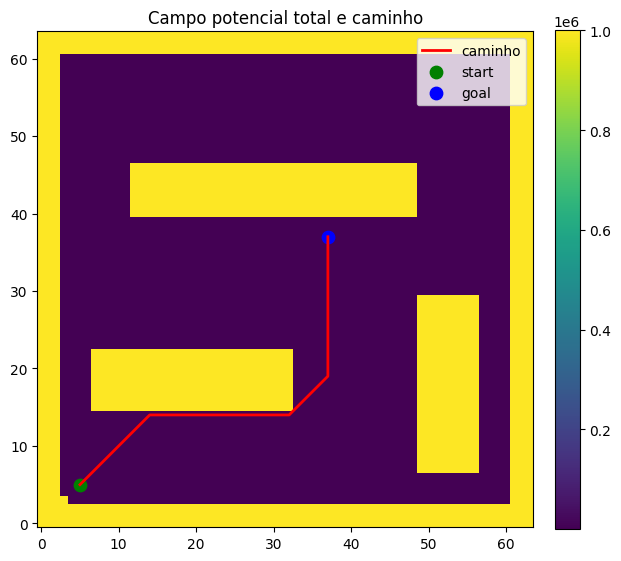

✅ Simulação iniciada e robô posicionado no ponto inicial!
🚗 Iniciando seguimento do caminho (diferencial)...
✅ Chegou ao waypoint 1/51


KeyboardInterrupt: 

In [8]:
# ============================
# Planner por Campos Potenciais + Execução (Robô Diferencial) novoooooo
# ============================

#procurar robo do professor


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import heapq

# tenta importar client do Coppelia; se não estiver disponível, avisa mas permite testar planner offline
try:
    from coppeliasim_zmqremoteapi_client import RemoteAPIClient
    COPPELIA_AVAILABLE = True
except Exception as e:
    print("⚠️ Atenção: coppeliasim_zmqremoteapi_client não encontrado. Apenas planner será executado. Erro:", e)
    COPPELIA_AVAILABLE = False


# ============================
# Ajustes do robô diferencial (ajuste conforme seu modelo no CoppeliaSim)
# ============================
robotname = 'PioneerP3DX'   # nome do robô na cena
left_wheel_name  = f'/{robotname}/leftMotor'   # nome completo do joint (use '/' + robotname + '/jointName')
right_wheel_name = f'/{robotname}/rightMotor'  # ajuste se for diferente na sua cena
r = 0.04    # raio da roda [m]
L = 0.135   # metade da distância entre rodas [m]
max_wheel_speed = 20.0  # rad/s, limite para velocidade das rodas


# ============================
# Funções utilitárias
# ============================
def pixel_to_world(x_px, y_px, img_size=64, world_size=10):
    """
    Converte coordenadas de pixel (x_px = coluna, y_px = linha) para coordenadas do CoppeliaSim (metros).
    O centro da imagem (img_size/2, img_size/2) corresponde à origem (0,0) no mundo.
    Retorna (x_world, y_world).
    """
    scale = world_size / img_size  # metros por pixel
    x_world = (x_px - img_size / 2) * scale
    y_world = -(y_px - img_size / 2) * scale  # inverte Y porque imagem cresce para baixo
    return x_world, y_world

def Rz(theta):
    """Matriz de rotação 3x3 no plano Z."""
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])


# ============================
# Carregar imagem e construir grid (64x64)
# ============================
img_path = '../mapas_meus/teste1_invertido.png'  # ajuste se necessário
img = mpimg.imread(img_path)

# inverter (já no seu código original você fazia 1 - imagem)
img = 1 - img

# limitar a dois níveis (0 e 1)
threshold = 0.5
img = img[..., 0] if img.ndim == 3 else img  # se imagem RGBA/ RGB, pega primeiro canal
img[img > threshold] = 1
img[img <= threshold] = 0

# dimensões do mapa (em células/meters) e escala
map_dims = np.array([64, 64])  # X,Y em "células"
img_h, img_w = img.shape[:2]

# escala para agrupar pixels em uma célula (caso imagem tenha maior resolução)
sy = img_h / map_dims[1]  # pixels por célula em Y (note a ordem)
sx = img_w / map_dims[0]  # pixels por célula em X

cell_size = 1  # metros por célula
rows, cols = map_dims[1], map_dims[0]  # rows=64, cols=64
grid = np.zeros((rows, cols), dtype=int)

# preencher grid: soma de pixels dentro da célula -> depois binariza
for r in range(rows):
    for c in range(cols):
        xi = int(round(c * sx))
        xf = int(round((c + 1) * sx))
        yi = int(round(r * sy))
        yf = int(round((r + 1) * sy))

        # clamp para bordas
        xi = max(0, min(img_w - 1, xi))
        xf = max(1, min(img_w, xf))
        yi = max(0, min(img_h - 1, yi))
        yf = max(1, min(img_h, yf))

        patch = img[yi:yf, xi:xf]
        if patch.size == 0:
            grid[r, c] = 0
        else:
            grid[r, c] = 1 if np.sum(patch) / patch.size > 0.5 else 0

# agora grid: 1 = ocupado, 0 = livre
grid = grid.astype(int)


# ============================
# Funções do planner por campo potencial (com fallback A*)
# ============================
def compute_distance_to_obstacles(grid):
    """Calcula distância euclidiana de cada célula até o obstáculo mais próximo."""
    rows, cols = grid.shape
    ys, xs = np.indices((rows, cols))
    obs = np.argwhere(grid == 1)
    if obs.size == 0:
        return np.full((rows, cols), np.hypot(rows, cols))
    oy = obs[:, 0][:, None, None]
    ox = obs[:, 1][:, None, None]
    dists = np.sqrt((ys[None, :, :] - oy)**2 + (xs[None, :, :] - ox)**2)
    dmin = dists.min(axis=0)
    return dmin

def potential_field_planner(grid, start, goal,
                            ka=1.0,
                            eta=300.0,
                            d0=6.0,
                            step_limit=20000,
                            visualize=True):
    """
    Monta campo potencial e obtém caminho por descida de gradiente.
    start, goal: (row, col)
    Retorna pos (dict idx -> (x_px, y_px)), path (lista de idx), U (campo potencial)
    """
    rows, cols = grid.shape
    sy, sx = np.indices((rows, cols))
    gy, gx = goal
    dist_to_goal = np.sqrt((sy - gy)**2 + (sx - gx)**2)
    U_att = 0.5 * ka * dist_to_goal**2

    dist_to_obs = compute_distance_to_obstacles(grid)
    U_rep = np.zeros_like(dist_to_obs, dtype=float)

    with np.errstate(divide='ignore', invalid='ignore'):
        mask = dist_to_obs <= d0
        U_rep[mask] = 0.5 * eta * (1.0 / (dist_to_obs[mask] + 1e-9) - 1.0 / d0)**2
        U_rep[grid == 1] = 1e6  # células ocupadas muito caras

    U = U_att + U_rep

    moves8 = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]

    cur = start
    path_coords = []
    visited = set()
    it = 0
    stuck_counter = 0
    max_stuck = 40

    while True:
        path_coords.append(cur)
        if cur == goal:
            break
        it += 1
        if it > step_limit:
            print("⚠️ Limite de iterações no gradiente excedido.")
            break

        cy, cx = cur
        cur_val = U[cy, cx]

        best = cur
        best_val = cur_val
        for dy, dx in moves8:
            ny, nx = cy + dy, cx + dx
            if 0 <= ny < rows and 0 <= nx < cols and grid[ny, nx] == 0:
                v = U[ny, nx]
                if v < best_val:
                    best_val = v
                    best = (ny, nx)

        if best == cur:
            stuck_counter += 1
            # tentativa de escape suave: escolher vizinho de menor valor (mesmo que maior que cur)
            smallest = None
            smallest_val = np.inf
            for dy, dx in moves8:
                ny, nx = cy + dy, cx + dx
                if 0 <= ny < rows and 0 <= nx < cols and grid[ny, nx] == 0:
                    v = U[ny, nx]
                    if v < smallest_val:
                        smallest_val = v
                        smallest = (ny, nx)
            if smallest is None:
                print("🚫 Start bloqueado.")
                break
            if smallest in visited or stuck_counter > max_stuck:
                print("🔁 Mínimo local detectado — fallback A*.")
                break
            cur = smallest
            visited.add(cur)
            continue
        else:
            cur = best
            visited.add(cur)

    # Se não chegou ao goal via gradiente, faz A*
    if path_coords[-1] != goal:
        def astar(grid, start, goal):
            rows, cols = grid.shape
            def h(a,b):
                return abs(a[0]-b[0]) + abs(a[1]-b[1])
            openset = []
            heapq.heappush(openset, (h(start,goal), 0, start, None))
            came_from = {}
            gscore = {start:0}
            closed = set()
            while openset:
                f, g, current, parent = heapq.heappop(openset)
                if current in closed:
                    continue
                came_from[current] = parent
                if current == goal:
                    path = []
                    cur = current
                    while cur is not None:
                        path.append(cur)
                        cur = came_from[cur]
                    return path[::-1]
                closed.add(current)
                cy, cx = current
                for dy, dx in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
                    ny, nx = cy+dy, cx+dx
                    if 0 <= ny < rows and 0 <= nx < cols and grid[ny,nx] == 0:
                        ng = g + np.hypot(dy, dx)
                        if (ny,nx) not in gscore or ng < gscore[(ny,nx)]:
                            gscore[(ny,nx)] = ng
                            heapq.heappush(openset, (ng + h((ny,nx), goal), ng, (ny,nx), current))
            return None

        astar_path = astar(grid, start, goal)
        if astar_path is None:
            raise RuntimeError("A* também falhou - não foi possível achar caminho")
        path_coords = astar_path
        print("✅ Caminho encontrado usando A* (fallback).")

    # converter para pos e path no formato esperado
    pos = {}
    path = []
    for i, (r, c) in enumerate(path_coords):
        pos[i] = (int(c), int(r))   # (x_px, y_px)
        path.append(i)

    # visualização
    if visualize:
        plt.figure(figsize=(7,7))
        plt.title("Campo potencial total e caminho")
        im = plt.imshow(U, origin='upper')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ys = [p[0] for p in path_coords]
        xs = [p[1] for p in path_coords]
        plt.plot(xs, ys, '-r', linewidth=2, label='caminho')
        plt.scatter([start[1]], [start[0]], c='green', s=80, label='start')
        plt.scatter([goal[1]], [goal[0]], c='blue', s=80, label='goal')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.show()

    return pos, path, U


# ============================
# Parâmetros Start / Goal (no formato row, col)
# ============================
start = (5, 5)
goal  = (37, 37)

# verificar se start/goal estão livres
if grid[start[0], start[1]] == 1:
    raise RuntimeError("Start está dentro de um obstáculo. Ajuste a posição inicial.")
if grid[goal[0], goal[1]] == 1:
    raise RuntimeError("Goal está dentro de um obstáculo. Ajuste a posição final.")

# rodar planner
pos, path, U = potential_field_planner(grid, start, goal,
                                       ka=1.0, eta=300.0, d0=6.0,
                                       step_limit=20000,
                                       visualize=True)

# ============================
# Converter pos -> pos_world (em metros) usando pixel_to_world
# ============================
pos_world = {}
for node, (x_px, y_px) in pos.items():
    pos_world[node] = pixel_to_world(x_px, y_px, img_size=64, world_size=10)


# ============================
# --- INÍCIO DA PARTE DE SIMULAÇÃO (CoppeliaSim) para robô diferencial ---
# ============================
if COPPELIA_AVAILABLE:
    client = RemoteAPIClient()
    sim = client.require("sim")

    try:
        sim.setStepping(True)
    except Exception:
        pass

    # pegar handle do robô (base)
    try:
        robotHandle = sim.getObject('/' + robotname)
    except Exception as e:
        try:
            robotHandle = sim.getObjectHandle('/' + robotname)
        except Exception as e2:
            raise RuntimeError("Não foi possível obter handle do robô no CoppeliaSim. Erros: " + str(e) + " / " + str(e2))

    # posição inicial (usar o primeiro nó do path)
    start_node = path[0]
    start_px = pos[start_node]  # (x_px, y_px) = (coluna, linha)
    start_pos_xy = pixel_to_world(start_px[0], start_px[1], img_size=64, world_size=10)
    start_pos = [start_pos_xy[0], start_pos_xy[1], 0.1]  # z pequeno
    start_ori = [0, 0, np.deg2rad(90)]  # orientação inicial (90°)

    # garantir sim parada antes de setar
    try:
        if sim.getSimulationState() != 0:
            sim.stopSimulation()
            time.sleep(1)
    except Exception:
        pass

    # setar posição e orientação
    try:
        sim.setObjectPosition(robotHandle, sim.handle_world, start_pos)
        sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori)
        sim.step()
    except Exception as e:
        print("⚠️ Warning: não foi possível setar posição/orientação diretamente. Erro:", e)

    # iniciar simulação
    try:
        sim.startSimulation()
        sim.step()
    except Exception as e:
        print("⚠️ Erro iniciando simulação:", e)

    print("✅ Simulação iniciada e robô posicionado no ponto inicial!")

    # handles das rodas (left/right) - tenta getObject, senão getObjectHandle
    try:
        left_wheel  = sim.getObject(left_wheel_name)
        right_wheel = sim.getObject(right_wheel_name)
    except Exception:
        left_wheel  = sim.getObjectHandle(left_wheel_name)
        right_wheel = sim.getObjectHandle(right_wheel_name)

    # parâmetros do controlador (P simples)
    K_v = 0.6      # ganho linear (afetar velocidade)
    K_omega = 2.0  # ganho angular (afetar rotação)

    # posição inicial do simulador (ler estado)
    try:
        pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
        ori_sim = sim.getObjectOrientation(robotHandle, sim.handle_world)
        q = np.array([pos_sim[0], pos_sim[1], ori_sim[2]])
    except Exception:
        q = np.array([start_pos[0], start_pos[1], np.deg2rad(90)])  # fallback

    # preparar waypoints (em metros)
    waypoints = [pos_world[node] for node in path]
    target_index = 0
    tolerance = 0.08  # metros

    print("🚗 Iniciando seguimento do caminho (diferencial)...")

    t0 = time.time()
    max_time = 300.0

    while target_index < len(waypoints):
        if time.time() - t0 > max_time:
            print("⏱️ Tempo máximo de execução atingido; interrompendo.")
            break

        # ler estado atual do robô (posição + orientação)
        try:
            pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
            ori_sim = sim.getObjectOrientation(robotHandle, sim.handle_world)
            q[0], q[1], q[2] = pos_sim[0], pos_sim[1], ori_sim[2]
        except Exception:
            # se leitura falhar, manter última estimativa q
            pass

        target = np.array(waypoints[target_index])
        erro = target - q[:2]
        dist = np.linalg.norm(erro)

        angulo_desejado = np.arctan2(erro[1], erro[0])
        erro_angulo = np.arctan2(np.sin(angulo_desejado - q[2]), np.cos(angulo_desejado - q[2]))

        # controlador P (linear + angular)
        v_linear = K_v * dist
        v_angular = K_omega * erro_angulo

        # limitar velocidades
        v_linear = np.clip(v_linear, -0.4, 0.4)      # m/s
        v_angular = np.clip(v_angular, -1.5, 1.5)   # rad/s

        # converter para velocidades angulares das rodas (rad/s) - modelo diferencial
        # formulas: v = r*(w_r + w_l)/2 ; omega = r*(w_r - w_l)/(2*L)
        # => w_r = (v + omega*L) / r ; w_l = (v - omega*L) / r
        w_r = (v_linear + v_angular * L) / r
        w_l = (v_linear - v_angular * L) / r

        # limitar velocidades das rodas
        w_r = np.clip(w_r, -max_wheel_speed, max_wheel_speed)
        w_l = np.clip(w_l, -max_wheel_speed, max_wheel_speed)

        # enviar velocidades
        try:
            sim.setJointTargetVelocity(left_wheel, float(w_l))
            sim.setJointTargetVelocity(right_wheel, float(w_r))
        except Exception as e:
            print("⚠️ Erro ao setar velocidades nas rodas:", e)

        # step da sim ou sleep conforme disponibilidade
        try:
            dt = sim.getSimulationTimeStep()
        except Exception:
            dt = 0.05
        try:
            sim.step()
        except Exception:
            time.sleep(dt)

        # checar chegada ao waypoint
        if dist < tolerance:
            print(f"✅ Chegou ao waypoint {target_index+1}/{len(waypoints)}")
            target_index += 1
            # opcional: parar brevemente
            try:
                sim.setJointTargetVelocity(left_wheel, 0)
                sim.setJointTargetVelocity(right_wheel, 0)
            except:
                pass
            time.sleep(0.08)

    # parar rodas no final
    try:
        sim.setJointTargetVelocity(left_wheel, 0)
        sim.setJointTargetVelocity(right_wheel, 0)
    except:
        pass

    print("🎯 Caminho concluído! (diferencial)")

    try:
        sim.stopSimulation()
    except:
        pass

    # exibir posição final no simulador
    try:
        posf = sim.getObjectPosition(robotHandle, sim.handle_world)
        orif = sim.getObjectOrientation(robotHandle, sim.handle_world)
        print('📍 Posição final no simulador:', posf)
        print('🧭 Orientação final (rad):', orif[2])
        print('🧭 Orientação final (graus):', np.rad2deg(orif[2]))
    except:
        pass

else:
    print("⚠️ CoppeliaSim não disponível — planner executado localmente. Resultado em `pos` e `path`.")
    print("Tamanho do caminho (nós):", len(path))
    if len(path) <= 50:
        for i in path[:min(50,len(path))]:
            print(i, "->", pos[i], "-> world:", pos_world[i])
    else:
        print("Primeiros 10 nós:", [(i, pos[i]) for i in path[:10]])
        print("Últimos 10 nós:", [(i, pos[i]) for i in path[-10:]])


In [ ]:
print(path)
print(G)
print(pos)
print(grid)

[(5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 6), (14, 7), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (14, 20), (14, 21), (14, 22), (14, 23), (14, 24), (14, 25), (14, 26), (14, 27), (14, 28), (14, 29), (14, 30), (14, 31), (14, 32), (14, 33), (15, 33), (16, 33), (17, 33), (18, 33), (18, 34), (18, 35), (18, 36), (18, 37), (19, 37), (20, 37), (21, 37), (22, 37), (23, 37), (24, 37), (25, 37), (26, 37), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37)]


In [27]:
# ============================
# Simulação e Seguimento de Caminho no CoppeliaSim
# ============================

import numpy as np
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# ============================
# Função: conversão de pixel -> mundo
# ============================
def pixel_to_world(x_px, y_px, img_size=64, world_size=10):
    """
    Converte coordenadas de pixel (imagem) para coordenadas do CoppeliaSim (em metros).
    O centro da imagem (32,32) corresponde à origem (0,0) no mundo.
    """
    scale = world_size / img_size  # metros por pixel
    x_world = (x_px - img_size / 2) * scale
    y_world = (y_px - img_size / 2) * scale  # invertido porque Y da imagem cresce para baixo
    return x_world, y_world


# ============================
# Função: matriz de rotação no plano Z
# ============================
def Rz(theta):
    """Retorna a matriz de rotação 3x3 no plano Z."""
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])


# ============================
# Conectar ao CoppeliaSim
# ============================
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

# Nome do robô
robotname = 'robotino'
robotHandle = sim.getObject('/' + robotname)

# ============================
# Conversão das posições do grafo (pixels -> mundo)
# ============================
pos_world = {}
for node, (x_px, y_px) in pos.items():
    pos_world[node] = pixel_to_world(x_px, y_px, img_size=64, world_size=10)

# ============================
# Posição inicial = primeiro nó do caminho
# ============================
start_node = path[0]
start_px = pos[start_node]
start_pos_xy = pixel_to_world(start_px[0], start_px[1], img_size=64, world_size=10)
start_pos = [start_pos_xy[0], start_pos_xy[1], 0.04]
start_ori = [0, 0, np.deg2rad(90)]  # orientação inicial (90° no plano XY)

# ============================
# Preparar simulação
# ============================
if sim.getSimulationState() != 0:
    sim.stopSimulation()
    time.sleep(1)

# Definir posição e orientação iniciais
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori)
sim.step()  # aplica transformações antes de iniciar

# ============================
# Iniciar simulação
# ============================
sim.startSimulation()
sim.step()

print("✅ Simulação iniciada e robô posicionado no ponto inicial do caminho!")

# ============================
# Handles das rodas
# ============================
wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')

# ============================
# Dados do robô
# ============================
L = 0.135   # distância do centro às rodas [m]
r = 0.040   # raio da roda [m]

# Matriz de cinemática direta (robo tipo Robotino)
Mdir = np.array([
    [-r/np.sqrt(3),     0,        r/np.sqrt(3)], 
    [r/3,            (-2*r)/3,    r/3], 
    [r/(3*L),         r/(3*L),    r/(3*L)]
])

# ============================
# Estado inicial do robô
# ============================
pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
q = np.array([pos_sim[0], pos_sim[1], np.deg2rad(90)])  # x, y, yaw inicial

# ============================
# Configuração de controle
# ============================
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.1  # metros

print("🚗 Iniciando seguimento do caminho...")

# ============================
# Loop principal
# ============================
while target_index < len(waypoints):
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Calcular erro de posição
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Calcular erro angular
    angulo_desejado = np.arctan2(erro[1], erro[0])
    erro_angulo = np.arctan2(np.sin(angulo_desejado - q[2]), np.cos(angulo_desejado - q[2]))

    # Controlador proporcional
    v_linear = 0.4 * dist
    v_angular = 1.5 * erro_angulo

    # Limitar velocidades
    v_linear = np.clip(v_linear, -0.3, 0.3)
    v_angular = np.clip(v_angular, -1.0, 1.0)

    # Cinemática inversa
    qdot = np.array([v_linear * np.cos(q[2]), v_linear * np.sin(q[2]), v_angular])
    Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
    u = Minv @ qdot

    # Enviar velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    # Atualizar posição estimada
    dt = sim.getSimulationTimeStep()
    q = q + (Rz(q[2]) @ Mdir @ u) * dt

    sim.step()

    # Verificar chegada
    if dist < tolerance:
        print(f"✅ Chegou em {path[target_index]} → indo para o próximo ponto")
        target_index += 1

# ============================
# Finalização
# ============================
# Parar o robô
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

print("🎯 Caminho concluído!")
sim.stopSimulation()

# Exibir posição final
pos = sim.getObjectPosition(robotHandle, sim.handle_world)
ori = sim.getObjectOrientation(robotHandle, sim.handle_world)
print('📍 Posição final no simulador:', pos)
print('🧭 Orientação final (graus):', np.rad2deg(ori))
print('🏁 Programa finalizado!')


✅ Simulação iniciada e robô posicionado no ponto inicial do caminho!
🚗 Iniciando seguimento do caminho...
✅ Chegou em (5, 5) → indo para o próximo ponto
✅ Chegou em (6, 5) → indo para o próximo ponto
✅ Chegou em (7, 5) → indo para o próximo ponto
✅ Chegou em (8, 5) → indo para o próximo ponto
✅ Chegou em (9, 5) → indo para o próximo ponto
✅ Chegou em (10, 5) → indo para o próximo ponto
✅ Chegou em (11, 5) → indo para o próximo ponto
✅ Chegou em (12, 5) → indo para o próximo ponto
✅ Chegou em (13, 5) → indo para o próximo ponto
✅ Chegou em (14, 5) → indo para o próximo ponto
✅ Chegou em (14, 6) → indo para o próximo ponto
✅ Chegou em (14, 7) → indo para o próximo ponto
✅ Chegou em (14, 8) → indo para o próximo ponto
✅ Chegou em (14, 9) → indo para o próximo ponto
✅ Chegou em (14, 10) → indo para o próximo ponto


KeyboardInterrupt: 